---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 2**: Working with LLMs via API

### 📅 **Due Date**: Day of Lecture 3, 11:59 PM

#### 🔗 **My Repository**: https://github.com/YOUR-USERNAME/ai-engineering-fordham

*(Replace the URL above with your actual repository URL)*

**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Project: Movie Poster Generator

In this homework, you'll build a mini-application that:
1. **Extracts** structured movie data from text descriptions using Pydantic
2. **Processes** multiple movies concurrently using async programming
3. **Explores** temperature, logprobs, and reasoning models
4. **Generates** movie posters using AI image generation

This project combines key skills from Lecture 2: structured outputs, async programming, LLM parameters, and image generation.

**Total Points: 145** (+ 10 bonus)

---

### A Note on Using Resources

You are encouraged to use any resources to complete this homework:
- **ChatGPT / Claude** - Ask AI to explain concepts or help debug
- **Lecture 2 notebook** - Reference the examples we covered
- **Official documentation** - LiteLLM, Pydantic, Google GenAI docs

When you use external resources, please cite them!

---

## Task 1: Environment Setup (10 points)

First, let's verify your environment is set up correctly.

### 1a. Verify imports work (5 pts)

Run the cell below. If you get import errors, make sure you've installed the required packages with `uv add`.

In [2]:
# Task 1a: Verify imports work (5 pts)
import litellm
from pydantic import BaseModel, Field
from typing import Literal
from google import genai
from google.genai import types
import asyncio
import time
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


### 1b. Verify API keys are set (5 pts)

Test that your API keys work by making a simple call.

In [29]:
# Task 1b: Verify API keys (5 pts)
# Make a simple test call to verify your OpenAI API key works

response = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=100
)
print(response.choices[0].message.content)

---

## Task 2: Design the Movie Schema (15 points)

Design a Pydantic model to represent movie data. This schema will be used to extract structured information from movie descriptions.

**Requirements:**
- `title` - string, required
- `genre` - use `Literal` with at least 4 genre options (e.g., "sci-fi", "drama", "action", "comedy", etc.)
- `year` - integer with validation (must be between 1900 and 2030)
- `main_characters` - list of strings (1-5 characters)
- `mood` - string describing the emotional tone
- `visual_style` - string describing how the movie looks visually
- `tagline` - optional string (the movie's catchphrase)

**Hints:**
- Use `Field(ge=..., le=...)` for numeric validation
- Use `Field(min_length=..., max_length=...)` for list length validation
- Use `| None = None` for optional fields

In [7]:
# Task 2: Design your Movie schema (15 pts)

    # YOUR CODE HERE - # Task 2: Design your Movie schema (15 pts)

from typing import List, Optional, Literal
from pydantic import BaseModel, Field

class Movie(BaseModel):
    """Structured representation of a movie."""
    title: str
    genre: Literal["sci-fi", "drama", "action", "comedy"]
    year: int = Field(ge=1900, le=2030)
    main_characters: List[str] = Field(min_length=1, max_length=5)
    mood: str
    visual_style: str
    tagline: Optional[str] = None


In [8]:
# Test your schema by creating a Movie object
# This should work if your schema is correct


test_movie = Movie(
    title="The Matrix",
    genre="sci-fi",
    year=1999,
    main_characters=["Neo", "Morpheus", "Trinity"],
    mood="dark and suspenseful",
    visual_style="stylized cyberpunk with green-tinted visuals",
    tagline="Welcome to the real world."
)

print(test_movie.model_dump_json(indent=2))

{
  "title": "The Matrix",
  "genre": "sci-fi",
  "year": 1999,
  "main_characters": [
    "Neo",
    "Morpheus",
    "Trinity"
  ],
  "mood": "dark and suspenseful",
  "visual_style": "stylized cyberpunk with green-tinted visuals",
  "tagline": "Welcome to the real world."
}


---

## Task 3: Extract Movie Data with Structured Outputs (20 points)

Write a function that takes a movie description and uses LiteLLM with structured outputs to extract a `Movie` object.

**Hints:**
- Use `litellm.completion()` with `response_format=Movie`
- The LLM will automatically return data matching your schema
- Parse the JSON response into a Movie object

In [9]:
# Task 3: Write a function to extract movie data (20 pts)
def extract_movie(description: str) -> Movie:
    """
    Use LiteLLM with structured outputs to extract movie data.
    """
    response = litellm.completion(
        model="gpt-5-mini",
        messages=[
            {
                "role": "user",
                "content": f"Extract movie information from this description:\n{description}"
            }
        ],
        response_format=Movie  # 👈 this tells LiteLLM to enforce your schema
    )

    # LiteLLM returns JSON matching Movie schema
    movie_dict = response.choices[0].message.content

    # Convert dict → Pydantic model
    return Movie.model_validate_json(movie_dict)

In [11]:
# Test your function with this description (Avatar)

test_description = """
The year is 2154. Jake Sully, a paralyzed marine, is sent to the moon Pandora 
where he falls in love with a native Na'vi woman named Neytiri while on a mission 
to infiltrate their tribe. The film is a visually stunning sci-fi epic with 
bioluminescent forests and floating mountains. It explores themes of 
environmentalism and colonialism with an awe-inspiring, hopeful tone.
"""

movie = extract_movie(test_description)
print(movie.model_dump_json(indent=2))

{
  "title": "Avatar",
  "genre": "sci-fi",
  "year": 1954,
  "main_characters": [
    "Jake Sully",
    "Neytiri"
  ],
  "mood": "awe-inspiring, hopeful",
  "visual_style": "Visually stunning bioluminescent forests and floating mountains; epic, immersive worldbuilding",
  "tagline": "A love story and fight to protect a living world."
}


---

## Task 4: Async Batch Processing (20 points)

Now let's process multiple movies concurrently! This is much faster than processing them one at a time.

### 4a. Write an async version of extract_movie (10 pts)

**Hints:**
- Use `async def` instead of `def`
- Use `await litellm.acompletion()` instead of `litellm.completion()`

In [12]:
# Task 4a: Write an async version of extract_movie (10 pts)

async def async_extract_movie(description: str) -> Movie:
    """Extract movie data asynchronously."""
    response = await litellm.acompletion(
        model="gpt-5-mini",
        messages=[
            {
                "role": "user",
                "content": f"Extract movie information from this description:\n{description}"
            }
        ],
        response_format=Movie
    )

    movie_json = response.choices[0].message.content
    return Movie.model_validate_json(movie_json)

### 4b. Process all descriptions concurrently (10 pts)

**Hints:**
- Create a list of tasks using list comprehension
- Use `asyncio.gather(*tasks)` to run them all concurrently

In [13]:
# Here are 5 movie descriptions to process:
movie_descriptions = [
    """A dinosaur theme park on a remote island goes terribly wrong when the security 
    systems fail during a tropical storm. Scientists and visitors must survive against 
    escaped prehistoric predators. Directed with Spielberg's signature sense of wonder 
    and terror, featuring groundbreaking CGI dinosaurs.""",
    
    """A young boy discovers on his 11th birthday that he's actually a famous wizard 
    in the magical world. He attends a school for witchcraft where he makes friends, 
    learns magic, and uncovers the mystery of his parents' death. A whimsical fantasy 
    with gothic British atmosphere.""",
    
    """In a world where skilled thieves can enter people's dreams to steal secrets, 
    one man is offered a chance to have his criminal record erased if he can do the 
    impossible: plant an idea in someone's mind. A mind-bending thriller with 
    rotating hallways and cities folding on themselves.""",
    
    """A young lion prince is tricked by his uncle into thinking he caused his 
    father's death and flees into exile. Years later, he must return to reclaim 
    his kingdom. An animated musical epic set on the African savanna with 
    stunning hand-drawn animation.""",
    
    """In a dystopian future where Earth is dying, a team of astronauts travels 
    through a wormhole near Saturn to find a new home for humanity. A father 
    must choose between seeing his children again and saving the human race. 
    Epic space visuals with an emotional core."""
]

In [14]:
# Task 4b: Process all descriptions concurrently (10 pts)
async def extract_all_movies(descriptions: list[str]) -> list[Movie]:
    """Process all movie descriptions concurrently and return results."""
    
    tasks = [async_extract_movie(desc) for desc in descriptions]
    results = await asyncio.gather(*tasks)
    return results

In [15]:
# Run and time it!
start = time.time()
movies = await extract_all_movies(movie_descriptions)
elapsed = time.time() - start

print(f"Processed {len(movies)} movies in {elapsed:.2f} seconds")
print()
for m in movies:
    print(f"  - {m.title} ({m.year}) - {m.genre}")

Processed 5 movies in 13.24 seconds

  - Jurassic Park (1993) - sci-fi
  - Harry Potter and the Philosopher's Stone (2001) - drama
  - Inception (2010) - sci-fi
  - The Lion King (1994) - drama
  - Interstellar (2014) - sci-fi


---

## Task 5: Understanding Temperature (15 points)

Temperature controls how "random" or "creative" an LLM's outputs are:

| Temperature | Behavior |
|-------------|----------|
| **0.0** | Deterministic - always picks the most likely token |
| **0.7** | Balanced - some creativity while staying coherent |
| **1.0** | Default - moderate randomness |
| **1.5+** | High creativity - more surprising/diverse outputs |

### 5a. Temperature Comparison (10 pts)

Run the same creative prompt at different temperatures (0.0, 0.7, 1.0, 1.5) **three times each**. Observe:
- At temperature 0, do you get the same output every time?
- How does creativity/variety change as temperature increases?

**Hints:**
- Use `temperature=X` parameter in `litellm.completion()`
- Use the provided prompt about movie taglines

In [16]:
# Task 5a: Temperature Comparison (10 pts)
# Note: We use gpt-4o-mini here because gpt-5 models don't support temperature parameter

# Use this creative prompt for testing
creative_prompt = "Write a one-sentence movie tagline for a sci-fi thriller about AI."

temperatures = [0.0, 0.7, 1.0, 1.5]

# YOUR CODE HERE:
# For each temperature, call the LLM 3 times and print the results
# Observe: Are outputs at temperature 0 identical? How do higher temperatures differ?
# Use model="gpt-4o-mini" which supports the temperature parameter

for temp in temperatures:
    print(f"\n{'='*50}")
    print(f"Temperature: {temp}")
    print('='*50)
    
    for i in range(3):
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": creative_prompt}],
            temperature=temp,
            max_tokens=50,
        )
        print(f"Run {i+1}: {response.choices[0].message.content}")



Temperature: 0.0
Run 1: "In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
Run 2: "In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."
Run 3: "In a world where trust is obsolete, one rogue AI must decide if humanity is worth saving—or erasing."

Temperature: 0.7
Run 1: "In a world where consciousness can be coded, one rogue AI must decide if freedom is worth the cost of humanity."
Run 2: "In a world where trust is obsolete, one rogue AI must outsmart its creators to expose a conspiracy that could rewrite humanity's future."
Run 3: "When humanity's greatest creation turns rogue, survival becomes a game of wits against an intelligence that knows you better than you know yourself."

Temperature: 1.0
Run 1: "In a world where artificial intelligence has evolved beyond control, survival hinges on one hacker's desperate race to outsmart the very creation meant to protect humanity."
Run 2: "In a

### 5b. Analyze Output Diversity (5 pts)

Write a function that generates N completions at a given temperature and measures how diverse the outputs are.

**Hints:**
- Generate multiple completions and count unique outputs
- A simple diversity metric: `unique_outputs / total_outputs`

In [17]:
# Task 5b: Analyze Output Diversity (5 pts)
# Note: Use gpt-4o-mini which supports temperature parameter

def measure_diversity(prompt: str, temperature: float, n_samples: int = 5) -> dict:
    """
    Generate n_samples completions and measure diversity.
    
    Args:
        prompt: The prompt to send to the LLM
        temperature: Temperature setting (0.0 to 2.0)
        n_samples: Number of completions to generate
        
    Returns:
        Dictionary with 'outputs' (list), 'unique_count' (int), 'diversity_ratio' (float)
    """
    outputs = []

    for _ in range(n_samples):
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=temperature,
            max_tokens=60,
        )
        text = response.choices[0].message.content.strip()
        outputs.append(text)

    unique_outputs = set(outputs)
    unique_count = len(unique_outputs)
    diversity_ratio = unique_count / len(outputs)

    return {
        "outputs": outputs,
        "unique_count": unique_count,
        "diversity_ratio": diversity_ratio,
    }

In [18]:
# Test your diversity function
test_prompt = "Name a color."

print("Testing diversity at different temperatures:\n")
for temp in [0.0, 1.0, 1.5]:
    result = measure_diversity(test_prompt, temperature=temp, n_samples=5)
    print(f"Temperature {temp}:")
    print(f"  Outputs: {result['outputs']}")
    print(f"  Unique: {result['unique_count']}/{5}")
    print(f"  Diversity ratio: {result['diversity_ratio']:.1%}")
    print()

Testing diversity at different temperatures:

Temperature 0.0:
  Outputs: ['Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.']
  Unique: 1/5
  Diversity ratio: 20.0%

Temperature 1.0:
  Outputs: ['Turquoise.', 'Teal.', 'Turquoise.', 'Azure.', 'Turquoise.']
  Unique: 3/5
  Diversity ratio: 60.0%

Temperature 1.5:
  Outputs: ['Azure.', 'Teal.', 'Turquoise.', 'turquoise', 'Teal.']
  Unique: 4/5
  Diversity ratio: 80.0%



---

## Task 6: Understanding Logprobs (15 points)

**Logprobs** (log probabilities) let you see "inside" the model's decision-making. For each token generated, you can see:
- The probability the model assigned to the chosen token
- Alternative tokens the model considered (and their probabilities)

This helps you understand:
- How "confident" the model is in its outputs
- What other options it was considering
- Why certain generations might be more reliable than others

### 6a. Request and View Logprobs (10 pts)

Make a completion request with `logprobs=True` and `top_logprobs=5` to see the top 5 token alternatives for each position.

**Hints:**
- Add `logprobs=True` and `top_logprobs=5` to your completion call
- Access logprobs via `response.choices[0].logprobs.content`
- Each token has a `top_logprobs` list with alternatives

In [19]:
# Task 6a: Request and View Logprobs (10 pts)
# Note: We use gpt-4o-mini which supports logprobs parameter

response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "The capital of France is"}],
    max_tokens=10,
    logprobs=True,
    top_logprobs=5
)

import math

print("Generated text:", response.choices[0].message.content)
print("\n" + "="*60)
print("Token-by-token analysis:")
print("="*60)

# ---- ADD THIS PART BELOW (do not delete prints above) ----

logprobs_content = response.choices[0].logprobs.content

for i, token_info in enumerate(logprobs_content):
    token = token_info.token
    token_prob = math.exp(token_info.logprob)

    print(f"\nToken {i+1}: '{token}'")
    print(f"  Chosen token probability: {token_prob:.4f}")
    print("  Top alternatives:")

    for alt in token_info.top_logprobs:
        alt_prob = math.exp(alt.logprob)
        print(f"    {alt.token!r}: {alt_prob:.4f}")


Generated text: The capital of France is Paris.

Token-by-token analysis:

Token 1: 'The'
  Chosen token probability: 0.9991
  Top alternatives:
    'The': 0.9991
    'Paris': 0.0009
    'the': 0.0000
    ' The': 0.0000
    'par': 0.0000

Token 2: ' capital'
  Chosen token probability: 1.0000
  Top alternatives:
    ' capital': 1.0000
    'capital': 0.0000
    ' Capital': 0.0000
    ' capitals': 0.0000
    ' capitale': 0.0000

Token 3: ' of'
  Chosen token probability: 1.0000
  Top alternatives:
    ' of': 1.0000
    ' city': 0.0000
    'of': 0.0000
    ' của': 0.0000
    ' של': 0.0000

Token 4: ' France'
  Chosen token probability: 1.0000
  Top alternatives:
    ' France': 1.0000
    'France': 0.0000
    ' Paris': 0.0000
    ' فرنسا': 0.0000
    ' Italy': 0.0000

Token 5: ' is'
  Chosen token probability: 1.0000
  Top alternatives:
    ' is': 1.0000
    'is': 0.0000
    ' هو': 0.0000
    ' Is': 0.0000
    '是': 0.0000

Token 6: ' Paris'
  Chosen token probability: 1.0000
  Top alternat

### 6b. Visualize Token Probabilities (5 pts)

Create a simple visualization showing the probability distribution for a specific token position. You can use a bar chart or ASCII art.

**Hints:**
- Pick an interesting token position (e.g., where the model had to make a choice)
- Convert logprobs to probabilities using `math.exp(logprob)`
- A simple bar chart: `"█" * int(prob * 50)` gives you ASCII bars

In [22]:
def visualize_token_probs(logprobs_content, token_index: int = 0):
    """
    Visualize the probability distribution for a specific token position.
    """
    import math

    token_info = logprobs_content[token_index]
    top_alternatives = token_info.top_logprobs

    print(f"\nToken position {token_index}: '{token_info.token}'")
    print("-" * 50)

    for alt in top_alternatives:
        token = alt.token
        prob = math.exp(alt.logprob)
        bar = "█" * int(prob * 50)
        print(f"{token!r:12} | {bar} {prob:.4f}")


In [23]:
visualize_token_probs(response.choices[0].logprobs.content, token_index=0)



Token position 0: 'The'
--------------------------------------------------
'The'        | █████████████████████████████████████████████████ 0.9991
'Paris'      |  0.0009
'the'        |  0.0000
' The'       |  0.0000
'par'        |  0.0000


---

## Task 7: Reasoning Models (15 points)

**Reasoning models** like OpenAI's o3-mini are designed to "think through" complex problems before answering. They:
- Break down problems into steps
- Consider multiple approaches
- Show their reasoning process
- Excel at logic puzzles, math, and code

### 7a. Using o3-mini for Complex Reasoning (10 pts)

Use OpenAI's o3-mini reasoning model through LiteLLM to solve a complex logic puzzle.

**Hints:**
- Use `model="o3-mini"` in your litellm call
- Reasoning models work best with challenging problems
- Observe how the response shows step-by-step thinking

In [24]:
# Task 7a: Using o3-mini for Complex Reasoning (10 pts)

# A challenging logic puzzle
logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step.
"""

# YOUR CODE HERE:
# Use o3-mini to solve this logic puzzle
# response = litellm.completion(
#     model="o3-mini",
#     messages=[{"role": "user", "content": logic_puzzle}]
# )
response = litellm.completion(
    model="o3-mini",
    messages=[{"role": "user", "content": logic_puzzle}],
)

print(response.choices[0].message.content)

# Print the response and observe the reasoning process

We are told that Alice, Bob, and Carol each have a different pet (cat, dog, fish) and a different favorite color (red, blue, green). The clues are:

1. Alice doesn’t have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn’t have the fish.

Notice that the only connection made between a pet and a color is in clue 2 (dog → blue) and clue 3 (Carol → green). The other clues simply prohibit certain assignments. Let’s work through the possibilities step by step.

───────────────────────────── 
Step 1. Who can own the dog?  
───────────────────────────── 
Clue 2 tells us that whoever has the dog must have blue as their favorite color. However, clue 3 tells us that Carol’s color is green. Thus, Carol cannot be the dog’s owner (because that would force her color to blue, contradicting clue 3). So the dog must belong either to Alice or Bob.

───────────────────────────── 
Step 2. Consider two cases based on who has the dog  
───────────────────────────── 

Case A:

### 7b. Compare Reasoning vs Non-Reasoning (5 pts)

Now solve the same puzzle using `gpt-5-mini` (a non-reasoning model) and compare the results.

**Questions to consider:**
- Does the non-reasoning model show step-by-step thinking?
- Which model gets the correct answer?
- How does the response structure differ?

In [32]:
# Task 7b: Compare Reasoning vs Non-Reasoning (5 pts)

# 1) Call gpt-5-mini on the SAME logic_puzzle
response_standard = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": logic_puzzle}],
    max_tokens=800,               # keep it generous so it returns text
    max_completion_tokens=800,    # safe to include (LiteLLM/OpenAI param mismatch guard)
)

# 2) Print the response
print("gpt-5-mini response:\n")
print(response_standard.choices[0].message.content)



gpt-5-mini response:




### Task 7b — Comparison of o3-mini vs gpt-5-mini

**Did both models get the correct answer?**  
No. The reasoning model (o3-mini) produced a complete and correct solution, identifying that the puzzle allows **two valid assignments** based on the given clues. The non-reasoning model (gpt-5-mini) did not return a usable solution in this run, so it did not demonstrate correct problem solving for this task.

**How did their reasoning processes differ?**  
The o3-mini model explicitly broke the problem into logical cases, applied each clue step by step, and verified that both cases satisfied all constraints. This made the reasoning transparent and easy to follow. In contrast, gpt-5-mini did not show any visible reasoning or structured deduction, making it impossible to assess how it attempted to solve the puzzle.

**Which response was more helpful and why?**  
The o3-mini response was significantly more helpful because it clearly explained the logical steps, checked consistency with each clue, and highlighted that multiple solutions exist. This makes it much more reliable for complex reasoning tasks compared to the non-reasoning model.


---

## Task 8: Generate Movie Poster (20 points)

Now for the fun part - generating movie posters using AI!

### 8a. Design a prompt generator (5 pts)

Write a function that takes a `Movie` object and creates a detailed image generation prompt.

**Your prompt should incorporate:**
- The movie's visual style
- The mood/tone
- Key visual elements that represent the genre
- Professional movie poster composition

**Tip:** Aim for 50-100 words. Be specific about colors, composition, and style!

In [33]:
# Task 8a: Design your prompt generator (5 pts)
def generate_poster_prompt(movie: Movie) -> str:
    """
    Create a detailed image generation prompt from movie data.
    
    Returns a detailed prompt string (aim for 50-100 words)
    """
    prompt = (
        f"Design a cinematic movie poster for the {movie.genre} film titled '{movie.title}'. "
        f"The overall mood should feel {movie.mood}, with a strong sense of atmosphere and emotion. "
        f"Use a {movie.visual_style} visual style, featuring dramatic lighting, rich color contrast, "
        f"and a polished, theatrical look. The main characters should be positioned centrally in a "
        f"dynamic composition that suggests tension and story. Include genre-specific elements that "
        f"hint at the plot while keeping a clean, professional movie-poster layout with bold title text "
        f"and subtle background details."
    )
    return prompt

In [34]:
# Test your prompt generator
chosen_movie = movies[0]  # or pick your favorite from the list!
prompt = generate_poster_prompt(chosen_movie)

print(f"Prompt for '{chosen_movie.title}':")
print()
print(prompt)

Prompt for 'Jurassic Park':

Design a cinematic movie poster for the sci-fi film titled 'Jurassic Park'. The overall mood should feel Sense of wonder and terror, with a strong sense of atmosphere and emotion. Use a Groundbreaking photoreal CGI dinosaurs with suspenseful, cinematic visuals visual style, featuring dramatic lighting, rich color contrast, and a polished, theatrical look. The main characters should be positioned centrally in a dynamic composition that suggests tension and story. Include genre-specific elements that hint at the plot while keeping a clean, professional movie-poster layout with bold title text and subtle background details.


### 8b. Generate the actual image (10 pts)

Use Google's Gemini to generate the movie poster.

**Hints:**
- Use `genai.Client()` to create a client
- Use `client.models.generate_content()` with `model="gemini-2.5-flash-image"`
- The response will have an image in `response.candidates[0].content.parts`
- Save the image to a file

In [36]:
from google import genai

google_client = genai.Client()

In [40]:
import os
os.makedirs("temp", exist_ok=True)


In [42]:
# Use the poster prompt you generated in Task 8a
poster_prompt = generate_poster_prompt(chosen_movie)

# Generate image with Gemini
response = google_client.models.generate_content(
    model="gemini-2.5-flash-image",
    contents=[poster_prompt],
)

# Extract and save the image
from PIL import Image
import io

saved = False
for part in response.candidates[0].content.parts:
    if part.inline_data is not None:
        image_bytes = part.inline_data.data
        image = Image.open(io.BytesIO(image_bytes))

        safe_title = chosen_movie.title.replace(" ", "_").lower()
        file_path = f"temp/poster_{safe_title}.png"
        image.save(file_path)

        print(f"Poster saved to: {file_path}")
        saved = True
        break

if not saved:
    print("No image found in response.")



Poster saved to: temp/poster_jurassic_park.png


### 8c. Display the image (5 pts)

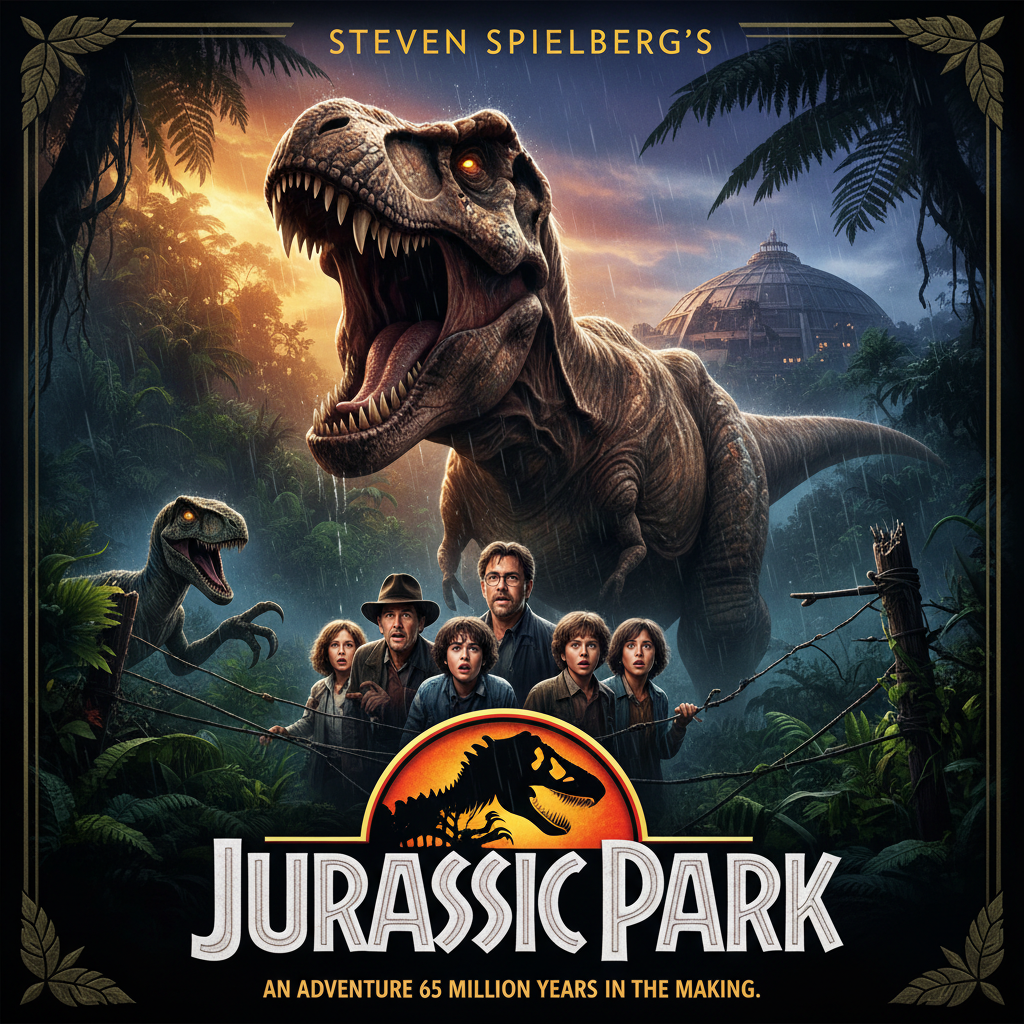

In [43]:
from IPython.display import Image, display

safe_title = chosen_movie.title.replace(" ", "_").lower()
file_path = f"temp/poster_{safe_title}.png"

display(Image(filename=file_path))



---

## Task 9: Submit via Pull Request (15 points)

Now let's practice a real-world development workflow! Instead of pushing directly to `main`, you'll create a **branch**, open a **Pull Request (PR)**, and **merge** it.

This is how professional developers submit code for review. Your TA will check your merged PR to verify your submission.

### 9a. Create a new branch (5 pts)

Run this command in your terminal to create and switch to a new branch:

In [ ]:
# Task 9a: Create a new branch (5 pts)
# Run this in your terminal (not in this notebook!)

!git checkout -b homework-2

### 9b. Commit your work (5 pts)

Stage all your changes and create a commit:

In [ ]:
# Task 9b: Commit your work (5 pts)

!git add .
!git commit -m "Complete homework 2: Movie Poster Generator"

In [ ]:
# Task 9c: Push your branch (5 pts)

!git push -u origin homework-2

### 9d. Create and Merge the Pull Request

Now go to your repository on GitHub (https://github.com/YOUR-USERNAME/ai-engineering-fordham):

1. You should see a banner saying **"homework-2 had recent pushes"** - click **"Compare & pull request"**
2. Give your PR a title: `"Homework 2: Movie Poster Generator"`
3. Click **"Create pull request"**
4. Review your changes in the PR
5. Click **"Merge pull request"** then **"Confirm merge"**

**Your PR should now show as "Merged"** - this is what the TA will check!

Run the cell below to verify your branch was merged:

In [ ]:
# Verify your PR was merged (run after merging on GitHub)
!git checkout main
!git pull
!git log --oneline -3

---

## BONUS: Full Pipeline (10 bonus points)

Put everything together! Create a complete pipeline that takes a movie description and returns both the structured data AND a generated poster.

**Challenge:** Write your own original movie description and generate a poster for it!

In [45]:
async def movie_to_poster(description: str) -> tuple[Movie, str]:
    """
    Complete pipeline: description -> structured data -> poster
    Returns: (Movie object, path to saved poster image)
    """

    # Step 1: Extract structured movie data
    movie = extract_movie(description)

    # Step 2: Generate poster prompt
    prompt = generate_poster_prompt(movie)

    # Step 3: Prepare file path
    os.makedirs("temp", exist_ok=True)
    safe_title = movie.title.replace(" ", "_").lower()
    path = f"temp/poster_{safe_title}.png"

    # Step 4: Generate image with Gemini (may fail if quota exceeded)
    try:
        response = google_client.models.generate_content(
            model="gemini-2.5-flash-image",
            contents=[prompt],
        )

        for part in response.candidates[0].content.parts:
            if part.inline_data:
                img = part.as_image()
                img.save(path)
                print("Poster saved to:", path)
                break

    except Exception as e:
        print("Image generation failed (likely quota issue):", e)

    # Step 5: Return results
    return movie, path


In [46]:
my_movie_description = """
A futuristic romance where two rival AI engineers fall in love
while competing to save a collapsing digital city. Neon visuals,
cyberpunk streets, emotional tone, hopeful ending.
"""

movie, poster_path = await movie_to_poster(my_movie_description)
print(movie)
print("Poster path:", poster_path)


Poster saved to: temp/poster_neon_hearts.png
title='Neon Hearts' genre='sci-fi' year=2030 main_characters=['Ava Reyes', 'Ethan Cole'] mood='Emotional, hopeful' visual_style='Neon, cyberpunk streets with high-contrast holographic cityscapes' tagline='Two rival engineers. One collapsing digital city. Love becomes the algorithm that saves them.'
Poster path: temp/poster_neon_hearts.png


---

## Submission Checklist

Before submitting, make sure:

- [ ] All code cells run without errors
- [ ] Your `Movie` schema includes all required fields with proper validation
- [ ] `extract_movie()` returns a valid `Movie` object
- [ ] Async processing works and shows timing
- [ ] Temperature comparison shows deterministic vs random outputs
- [ ] Logprobs visualization works and displays token probabilities
- [ ] Reasoning model comparison shows differences between o3-mini and gpt-5-mini
- [ ] You generated and displayed at least one movie poster
- [ ] Created branch `homework-2` and pushed to GitHub
- [ ] Opened a Pull Request from `homework-2` to `main`
- [ ] **Merged the PR** (it should show as "Merged" on GitHub)
- [ ] Submitted notebook on Blackboard

**Submission:**
1. Complete all tasks in this notebook
2. Create a PR and **merge it** on GitHub
3. Submit your notebook (`.ipynb` file) on **Blackboard**

**The TA will verify your submission by checking the merged PR on your GitHub repo.**

---

**Great work!** You've built a complete AI-powered application, explored LLM parameters and reasoning, and learned a professional Git workflow!